In [176]:
import warnings
import itertools 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

In [177]:
# Abrir archivos

load = pd.read_csv('./data_by_type/load_df.csv')
solar = pd.read_csv('./data_by_type/solar_df.csv')
wind = pd.read_csv('./data_by_type/wind_df.csv')
price = pd.read_csv('./data_by_type/price_df.csv')

In [178]:
data = pd.read_csv('time_series_60min_singleindex.csv')
data.utc_timestamp[0], data.utc_timestamp[1], data.utc_timestamp[2], data.utc_timestamp[50400]

('2014-12-31T23:00:00Z',
 '2015-01-01T00:00:00Z',
 '2015-01-01T01:00:00Z',
 '2020-09-30T23:00:00Z')

In [179]:
# Eliminar columna 'Unnamed: 0'
load.drop('Unnamed: 0', axis=1, inplace=True)
# Insertar columna del total generado
load.loc[:,'Total_load_generation']= load.sum(numeric_only=True, axis=1)
# Obtener df
load = load[['Total_load_generation']]
load

,Total_load_generation
0,0.00
1,173297.00
2,429928.01
3,409873.88
4,399087.36
...,...
50396,584344.69
50397,545213.42
50398,505798.23
50399,467698.88


In [180]:
load['Total_load_generation'][44589] = 602579.08

In [181]:
load[44586:44592]

,Total_load_generation
44586,664810.92
44587,655943.81
44588,628225.98
44589,602579.08
44590,576932.19
44591,551789.48


In [182]:
load.tail()

,Total_load_generation
50396,584344.69
50397,545213.42
50398,505798.23
50399,467698.88
50400,218003.00


In [183]:
load.drop([50399,50400], axis=0, inplace=True)
load.tail()

,Total_load_generation
50394,640644.80
50395,623591.21
50396,584344.69
50397,545213.42
50398,505798.23


array([[<AxesSubplot:title={'center':'Total_load_generation'}>]],
      dtype=object)

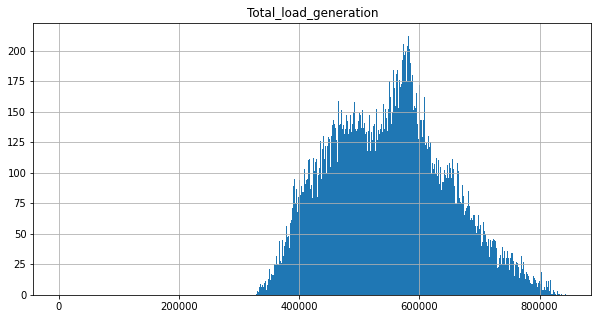

In [184]:
# histograma
load.hist(bins=1000)

<AxesSubplot:>

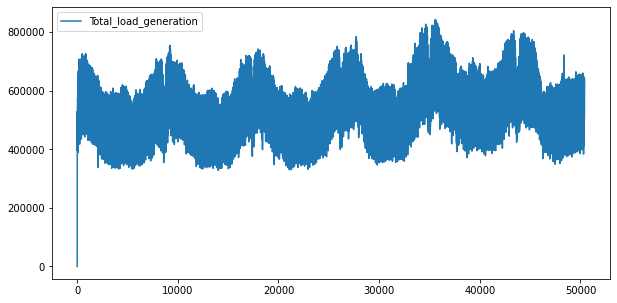

In [185]:
load.plot()

In [186]:
# timestamps

date_1h = pd.date_range(start='12/31/2014 23:00:00', 
                        end='09/30/2020 21:00:00', 
                        freq='H')


In [187]:
# verificar dimensiones de fechas y df
len(date_1h), load.shape

(50399, (50399, 1))

In [188]:
# convertir timestamp en serie de pandas
date_ser_1h = pd.Series(date_1h, name='date')

# concatenar dataframes
load_df = pd.concat([load, date_ser_1h], axis=1)

# resetear indice
load_df.set_index('date', inplace=True, drop=True)
load_df

,Total_load_generation
date,
2014-12-31 23:00:00,0.00
2015-01-01 00:00:00,173297.00
2015-01-01 01:00:00,429928.01
2015-01-01 02:00:00,409873.88
2015-01-01 03:00:00,399087.36
...,...
2020-09-30 17:00:00,640644.80
2020-09-30 18:00:00,623591.21
2020-09-30 19:00:00,584344.69


In [189]:
rcParams['figure.figsize'] = 10, 5

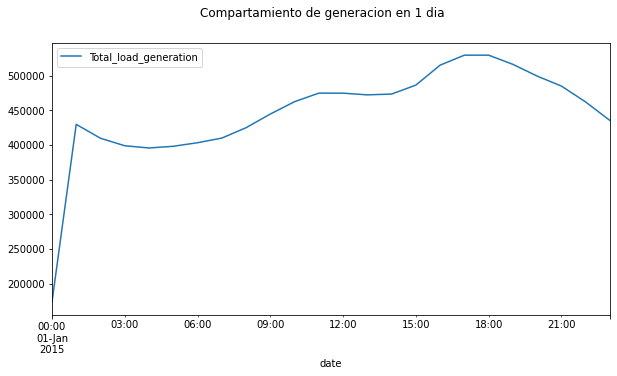

In [190]:
# Analizar comportamiento por hora
load_df.iloc[1:25].plot() # 24 rangos de 1 hora para ver comportamiento en 1 dia
plt.suptitle('Compartamiento de generacion en 1 dia');

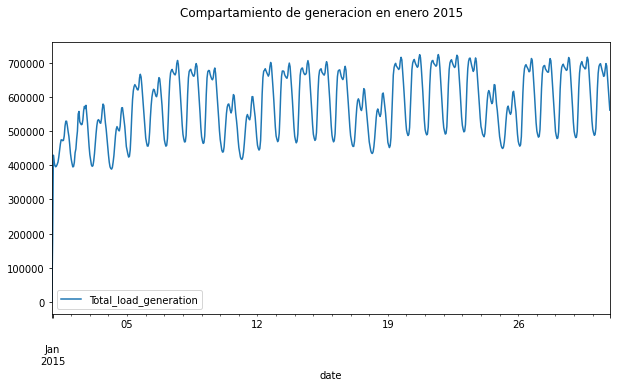

In [191]:
# Analizar comportamiento por mes
load_df.iloc[:24*30].plot() # 24 rangos de 1 hora para ver comportamiento en 1 dia
plt.suptitle('Compartamiento de generacion en enero 2015');

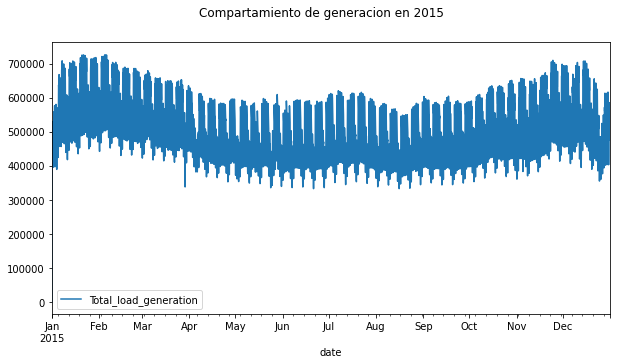

In [192]:
# Analizar comportamiento por año 2015
load_df.iloc[:24*365].plot() # 24 rangos de 1 hora para ver comportamiento en 1 dia
plt.suptitle('Compartamiento de generacion en 2015');

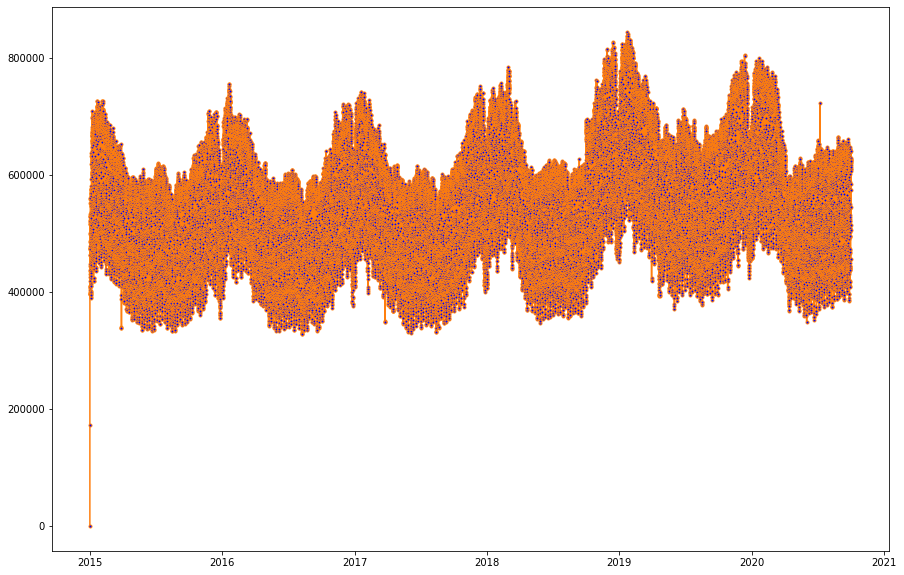

<Figure size 720x360 with 0 Axes>

In [193]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.figure(facecolor='w')

ax.plot(load_df, marker='o', markersize=3, markerfacecolor='b', color='tab:orange')


In [194]:
# Examinar el valor extraordinario en 2020
load_df.sort_values(by='Total_load_generation').tail(10)

# 01 de febrero del 2020 hubo generacvión del 400%

,Total_load_generation
date,
2019-01-31 09:00:00,830806.10
2019-01-24 10:00:00,831040.15
2019-01-24 16:00:00,831575.20
2019-01-22 18:00:00,833429.19
2019-01-24 09:00:00,833886.35
2019-01-23 16:00:00,836184.32
2019-01-24 17:00:00,836389.52
2019-01-22 16:00:00,837620.01
2019-01-23 17:00:00,841012.06


In [195]:
load.sort_values(by='Total_load_generation').tail(1)

,Total_load_generation
35586,843834.77


In [196]:
data.loc[[44589],:]
# Slovakia had a peak on energy generation

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
44589,2020-02-01T20:00:00Z,2020-02-01T21:00:00+0100,6627.0,6898.0,NaN,0.0,1751.0,8882.0,9458.0,0.0,...,NaN,1497.0,0.09,0.2,2170811.0,3180.0,0.6,0.8,17401.0,19520.0


### Aplicar prueba Dickey Fuller

In [197]:
class Stationary:
  def __init__(self, significance=0.05):
    self.significance_level = significance
    self.pvalue = None # estos valores pueden alterar los valores de la prueba de hipotesis, en este caso no se modifican
    self.is_stationary = None

  def ADF(self, values):
    result = adfuller(values, autolag='AIC')

    format_results = pd.Series(result[:4], 
                                index=['Statistic', 'P-value',
                                      'Num of Lags', 'Observations'])
    for k,v in result[4].items():
      format_results[f'Critical Value {k}'] = v

    return format_results

In [198]:
def viewing_stationarity(df, window=5):
  """Esta función genera un plot para una serie de tiempo
     con su media móvil y su desviación estándar.
  """

  rolmean = df.rolling(window=window).mean()
  rolstd = df.rolling(window=window).std()

  fig = plt.figure(figsize=(10, 5))
  time_series = plt.plot(df, color='blue', label='original')
  mean = plt.plot(rolmean, color='red', label='media móvil')
  std = plt.plot(rolstd, color='green', label='desviación estándar móvil')
  plt.legend(loc='best')
  plt.show();

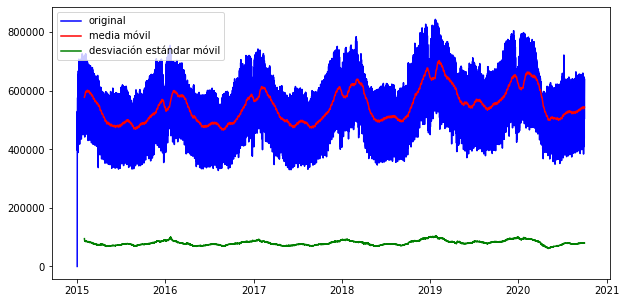

In [199]:
# Estacionaridad por mes
viewing_stationarity(load_df, window=24*30)

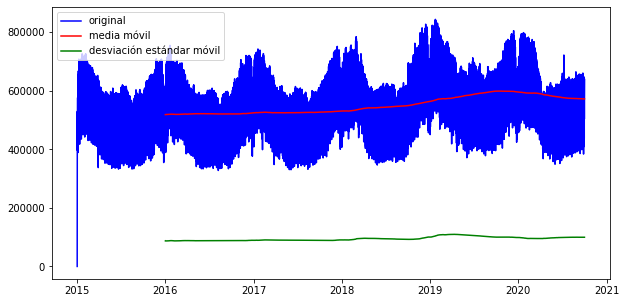

In [200]:
# Estacionaridad por año
viewing_stationarity(load_df, window=24*365)

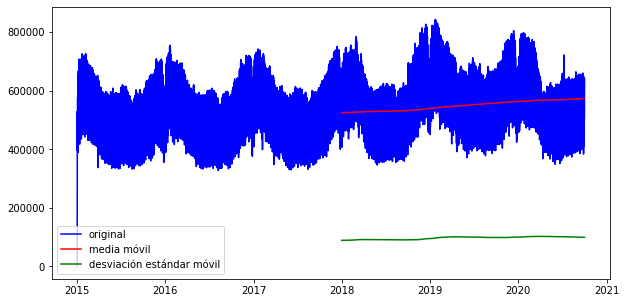

In [201]:
# Estacionaridad por 3 años
viewing_stationarity(load_df, window=24*365*3)

### Recordar que al aplicar una prueba ADF las hipótesis se determinan como se muestra:

H0 = Nuestros datos no son estacionarios

H1 = Nuestros datos sí son estacionarios

In [202]:
adf_test = Stationary()
adf_test.ADF(load_df['Total_load_generation'].values).round(5)

Statistic               -13.07511
P-value                   0.00000
Num of Lags              57.00000
Observations          50341.00000
Critical Value 1%        -3.43048
Critical Value 5%        -2.86160
Critical Value 10%       -2.56680
dtype: float64

#### Por lo que se puede concluir que los datos sí son estacionarios, dado p_value << al 5%

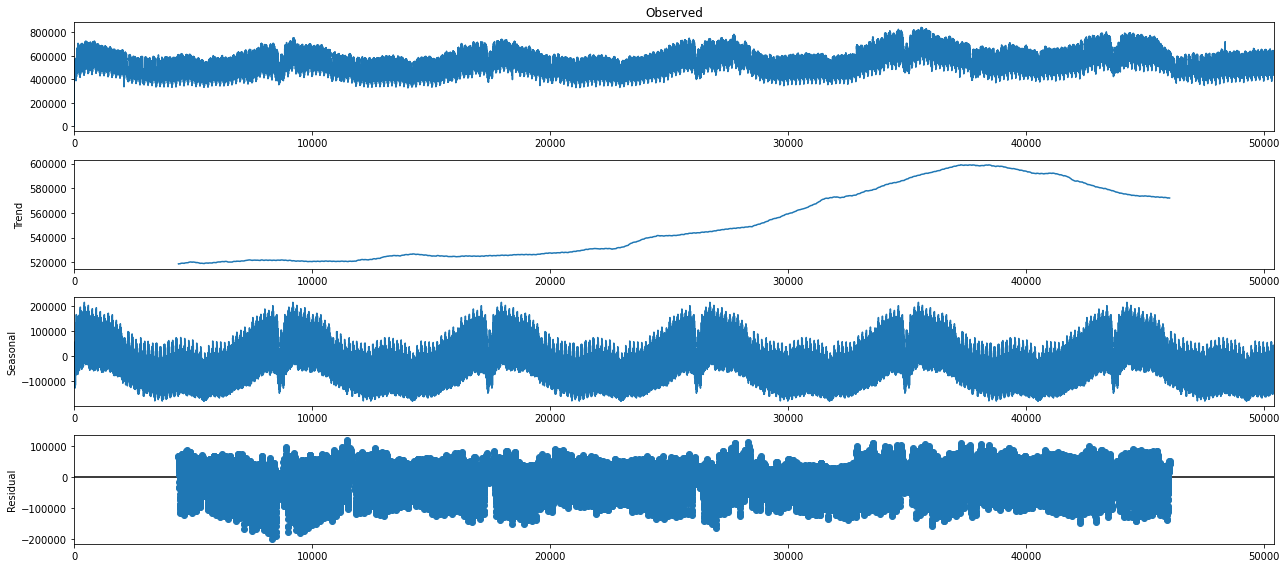

In [203]:
rcParams['figure.figsize'] = 18, 8

load_series = pd.Series(load_df['Total_load_generation'])
decomposition = sm.tsa.seasonal_decompose(load_series.values, period=24*365)
fig = decomposition.plot()
plt.show();

### Se observa tendencia a la alza en los datos por año

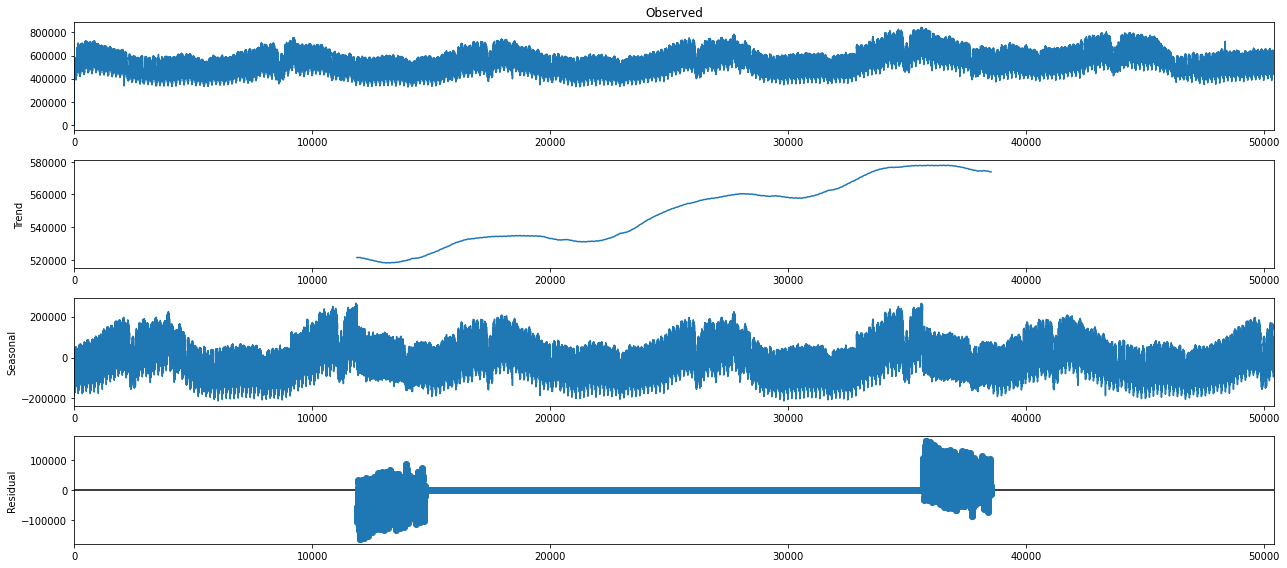

In [204]:
load_series = pd.Series(load_df['Total_load_generation'])
decomposition = sm.tsa.seasonal_decompose(load_series.values, period=24*330*3)
fig = decomposition.plot()
plt.show();

### Clara tendencia a la alza en los ultimos 3 años

### Graficar Autocorrelacion

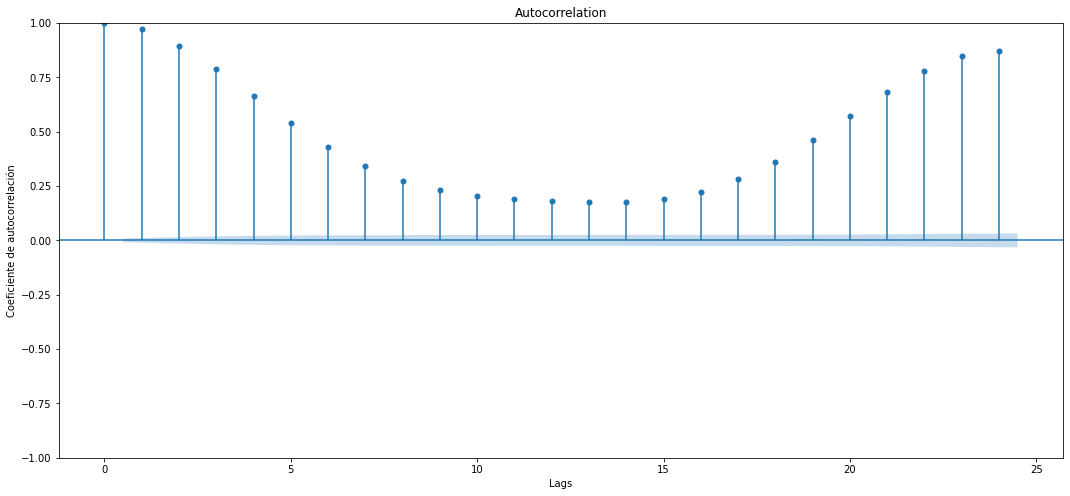

In [205]:
# Por día
tsaplots.plot_acf(load_df['Total_load_generation'].values.squeeze(), lags=24)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

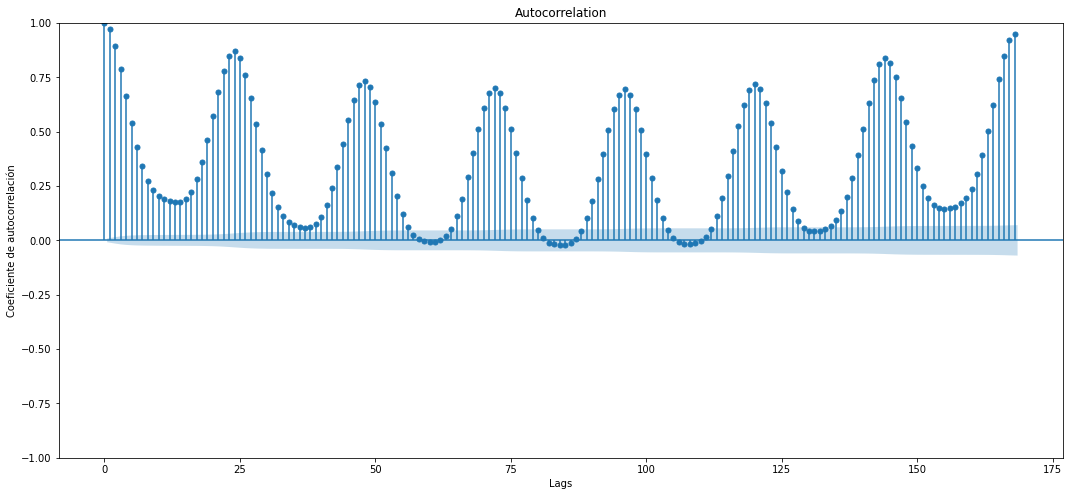

In [206]:
# Por semana
tsaplots.plot_acf(load_df['Total_load_generation'].values.squeeze(), lags=24*7)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

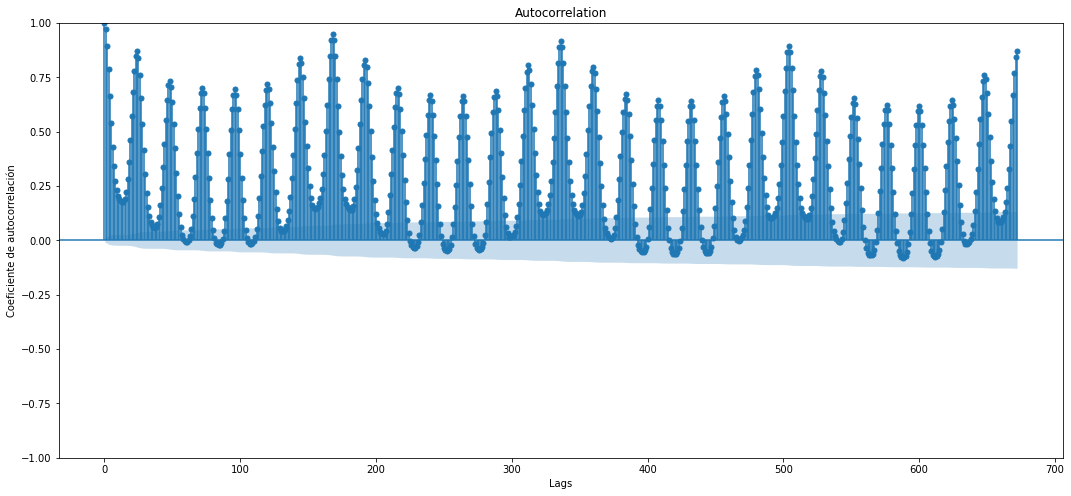

In [207]:
# Por mes
tsaplots.plot_acf(load_df['Total_load_generation'].values.squeeze(), lags=24*7*4)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

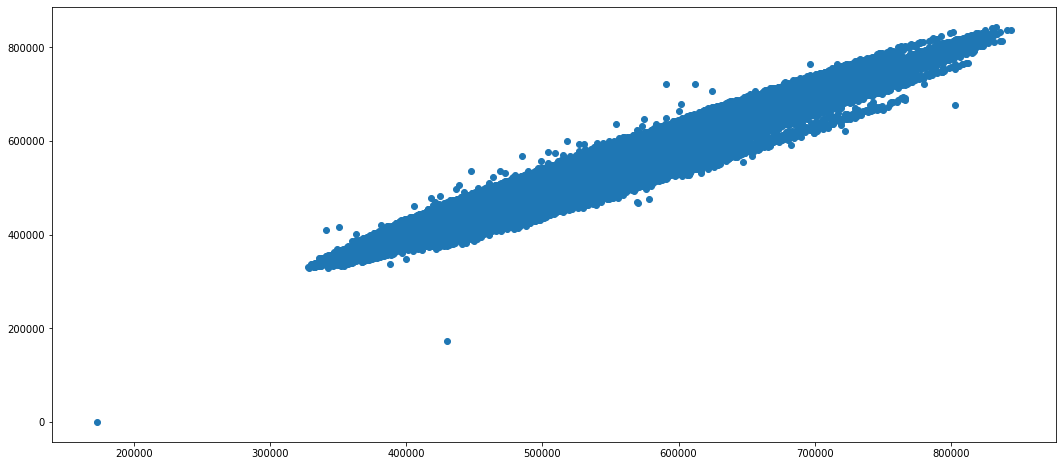

In [208]:
plt.scatter(load_df['Total_load_generation'], load_df['Total_load_generation'].shift(1));

### Diferenciacion

In [209]:
load_df['Total_load_shift1'] = load_df['Total_load_generation'].shift(1)
load_df['diff_1'] = load_df['Total_load_generation'] - load_df['Total_load_shift1']
load_df.head()

,Total_load_generation,Total_load_shift1,diff_1
date,,,
2014-12-31 23:00:00,0.00,NaN,NaN
2015-01-01 00:00:00,173297.00,0.00,173297.00
2015-01-01 01:00:00,429928.01,173297.00,256631.01
2015-01-01 02:00:00,409873.88,429928.01,-20054.13
2015-01-01 03:00:00,399087.36,409873.88,-10786.52


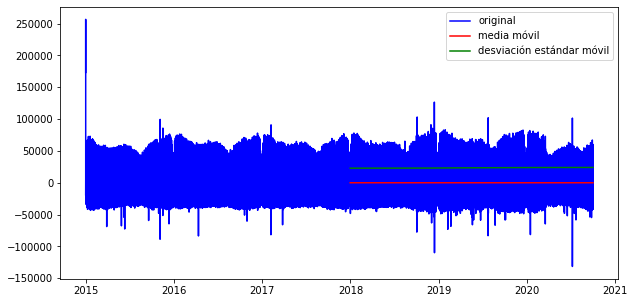

Statistic               -40.583294
P-value                   0.000000
Num of Lags              57.000000
Observations          50340.000000
Critical Value 1%        -3.430480
Critical Value 5%        -2.861597
Critical Value 10%       -2.566801
dtype: float64

In [210]:
viewing_stationarity(load_df['diff_1'].dropna(), window=24*365*3)
adf_test = Stationary()
adf_test.ADF(load_df['diff_1'].dropna().values).round(6)

In [211]:
# Definimos los rangos en los que vamos a probar PDQ

p = d = q = range(0, 3)
p, d, q

(range(0, 3), range(0, 3), range(0, 3))

In [212]:
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [213]:
# concatenar dataframes
load_df_2 = pd.concat([load, date_ser_1h], axis=1)

# resetear indice
load_df_2.set_index('date', inplace=True, drop=True)
load_df_2

,Total_load_generation
date,
2014-12-31 23:00:00,0.00
2015-01-01 00:00:00,173297.00
2015-01-01 01:00:00,429928.01
2015-01-01 02:00:00,409873.88
2015-01-01 03:00:00,399087.36
...,...
2020-09-30 17:00:00,640644.80
2020-09-30 18:00:00,623591.21
2020-09-30 19:00:00,584344.69


In [214]:
model = list()
aic = list() # indicador aikake (OSL) buscar

for param in pdq:
    try:
        mod = SARIMAX(load_df_2, order=param, enforce_stationarity=False) # con esto el modelo ya no es SARIMAX, es ARIMA
        results = mod.fit()
        model.append(param)
        aic.append(results.aic) # Aikake Information Criterion
        print('ARIMA{}-AIC{}'.format(param, results.aic))
    except:
        print('')
        print('No pude correr el modelo')
        continue

ARIMA(0, 0, 0)-AIC1476590.3839834726
ARIMA(0, 0, 1)-AIC1438856.4561765215
ARIMA(0, 0, 2)-AIC1429402.6004332914
ARIMA(0, 1, 0)-AIC1157324.7726690376
ARIMA(0, 1, 1)-AIC1117593.6919154185
ARIMA(0, 1, 2)-AIC1095945.9642996758
ARIMA(0, 2, 0)-AIC1100538.162371047
ARIMA(0, 2, 1)-AIC1091005.2832676768
ARIMA(0, 2, 2)-AIC1089628.1872825315
ARIMA(1, 0, 0)-AIC1157381.2679514317
ARIMA(1, 0, 1)-AIC1114162.6711913687
ARIMA(1, 0, 2)-AIC1095488.8087818604
ARIMA(1, 1, 0)-AIC1096313.007417759
ARIMA(1, 1, 1)-AIC1084931.2296363465
ARIMA(1, 1, 2)-AIC1080959.4385450752
ARIMA(1, 2, 0)-AIC1091792.7157524123
ARIMA(1, 2, 1)-AIC1090357.1916478719
ARIMA(1, 2, 2)-AIC1089339.4507585135
ARIMA(2, 0, 0)-AIC1096060.540854089
ARIMA(2, 0, 1)-AIC1085036.0745868583
ARIMA(2, 0, 2)-AIC1081244.4400327743
ARIMA(2, 1, 0)-AIC1080100.6255056136
ARIMA(2, 1, 1)-AIC1079888.783572323
ARIMA(2, 1, 2)-AIC1074953.2486963347
ARIMA(2, 2, 0)-AIC1089799.623427942
ARIMA(2, 2, 1)-AIC1080321.4707928665
ARIMA(2, 2, 2)-AIC1080011.0736937851


In [215]:
df_model_load = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_model_load.sort_values('aic').head()

,model,aic
23,"(2, 1, 2)",1.074953e+06
22,"(2, 1, 1)",1.079889e+06
26,"(2, 2, 2)",1.080011e+06
21,"(2, 1, 0)",1.080101e+06
25,"(2, 2, 1)",1.080321e+06


In [216]:
model_load = SARIMAX(load_df_2,  order=(2,1,2), enforce_stationarity=False)

results = model_load.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Total_load_generation   No. Observations:                50399
Model:                  SARIMAX(2, 1, 2)   Log Likelihood             -537471.624
Date:                   Fri, 13 May 2022   AIC                        1074953.249
Time:                           03:49:59   BIC                        1074997.387
Sample:                       12-31-2014   HQIC                       1074967.070
                            - 09-30-2020                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7244      0.003    643.785      0.000       1.719       1.730
ar.L2         -0.8236      0.003   -328.498      0.000      -0.829      -0.819
ma.L1         -0.6141      0.002   -264.199      0.000      -0.619      -0.610
ma.L2         -0.3234      0.002   -144.041      0.000      -0.328      -0.319
sigma2      1.151e+08   7.65e-12    1.5e+19      0.000    1.15e+08    1.15e+08
===================================================================================
Ljung-Box (L1) (Q):                  65.78   Jarque-Bera (JB):            578013.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+32. Standard errors may be unstable.
"""

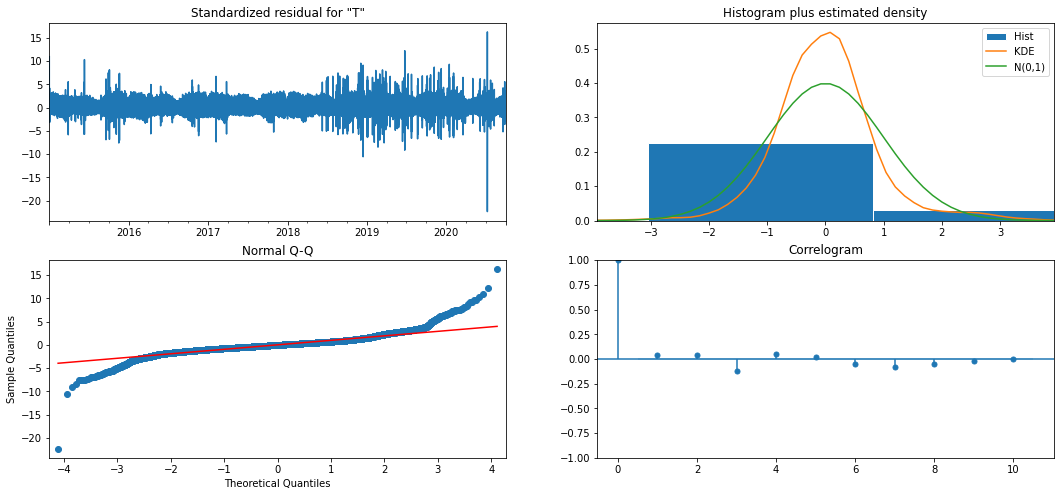

In [217]:
results.plot_diagnostics()
plt.show()

### Predicciones

In [218]:
load_df.shape[0]*0.80

40319.200000000004

In [219]:
load_df.reset_index().iloc[40_321, 0]

Timestamp('2019-08-08 00:00:00')

In [220]:
start = load_df.reset_index().iloc[40_321, 0]
end = load_df.reset_index().iloc[-1, 0]
start, end

(Timestamp('2019-08-08 00:00:00'), Timestamp('2020-09-30 21:00:00'))

In [221]:
pred = results.predict(start=start, end=end)
pred_ci = results.get_prediction(start=start, end=end).conf_int()

df_pred = pd.DataFrame(pred)
df_pred.head()

,predicted_mean
2019-08-08 00:00:00,444130.477356
2019-08-08 01:00:00,444351.380112
2019-08-08 02:00:00,439951.407028
2019-08-08 03:00:00,450697.896387
2019-08-08 04:00:00,481164.832450


In [222]:
pred_ci.head()

,lower Total_load_generation,upper Total_load_generation
2019-08-08 00:00:00,423099.525647,465161.429065
2019-08-08 01:00:00,423320.428403,465382.331822
2019-08-08 02:00:00,418920.455319,460982.358737
2019-08-08 03:00:00,429666.944678,471728.848096
2019-08-08 04:00:00,460133.880741,502195.784159


In [223]:
df_prediction = pd.concat([df_pred, pred_ci], axis=1)
df_prediction.head()

,predicted_mean,lower Total_load_generation,upper Total_load_generation
2019-08-08 00:00:00,444130.477356,423099.525647,465161.429065
2019-08-08 01:00:00,444351.380112,423320.428403,465382.331822
2019-08-08 02:00:00,439951.407028,418920.455319,460982.358737
2019-08-08 03:00:00,450697.896387,429666.944678,471728.848096
2019-08-08 04:00:00,481164.832450,460133.880741,502195.784159


<AxesSubplot:>

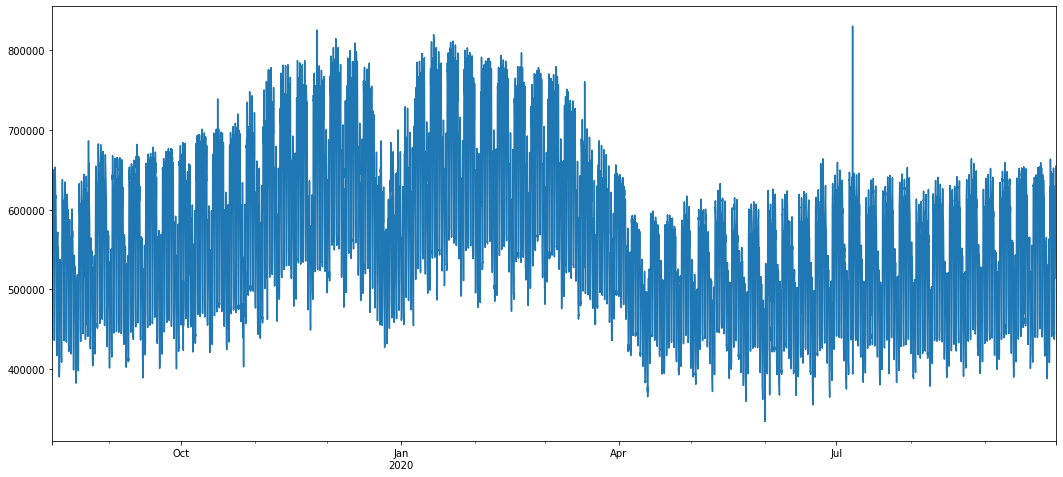

In [224]:
df_prediction['predicted_mean'].plot()

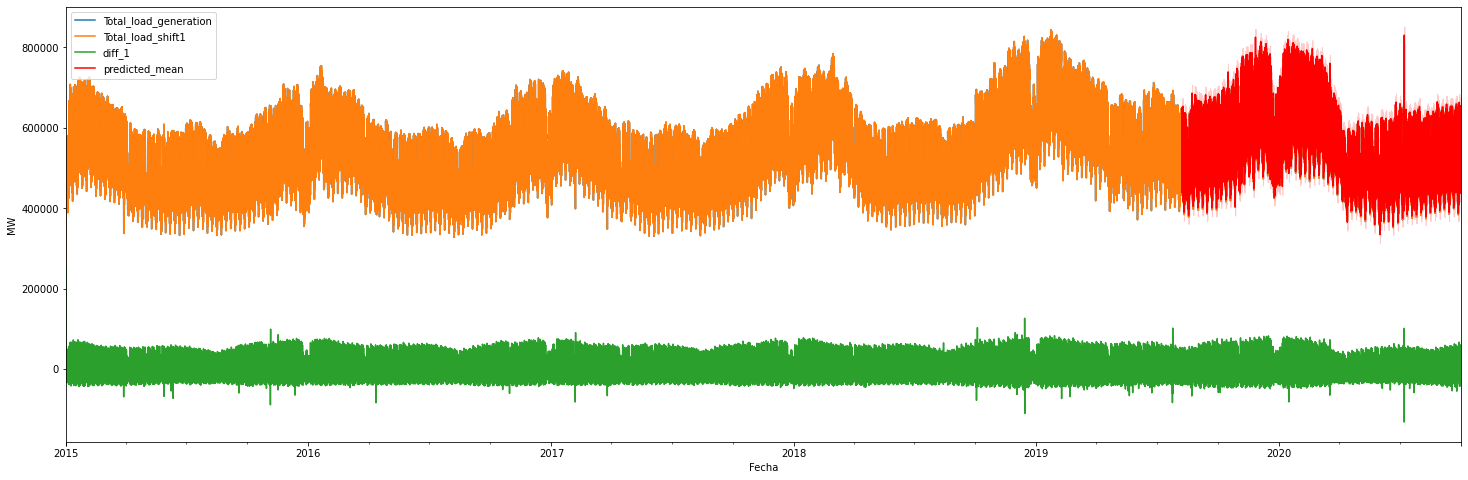

In [225]:
rcParams['figure.figsize'] = 25, 8
ax = load_df.plot(label='observed')
df_prediction['predicted_mean'].plot(c='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('MW')
plt.legend()

plt.show()

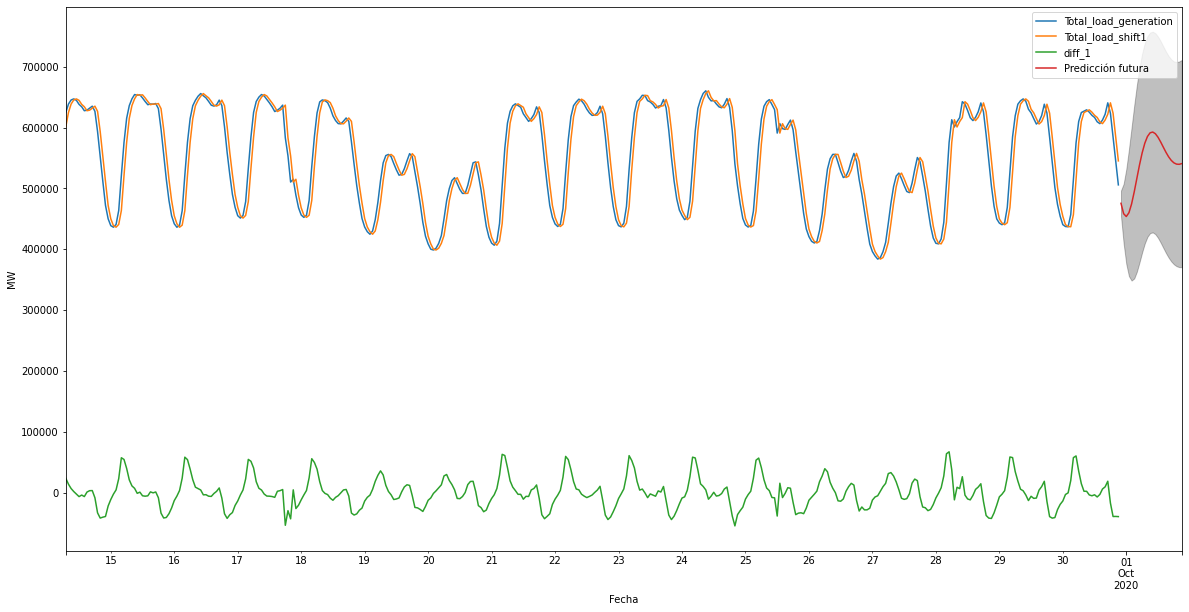

In [226]:
rcParams['figure.figsize'] = 25, 8

pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = load_df.iloc[50_000:].plot(label='Observado', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción futura')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### Usando Facebook Prophet

In [229]:
import seaborn as sns 
import pylab as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error

ModuleNotFoundError: No module named 'fbprophet'

In [230]:
pip list

Package                Version
---------------------- ---------
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
astor                  0.8.1
asttokens              2.0.5
async-generator        1.10
attrs                  21.4.0
autograd               1.4
autograd-gamma         0.5.0
backcall               0.2.0
beautifulsoup4         4.10.0
bleach                 4.1.0
bs4                    0.0.1
certifi                2021.10.8
cffi                   1.15.0
charset-normalizer     2.0.12
chart-studio           1.1.0
colorama               0.4.4
colorlover             0.3.0
cryptography           36.0.2
cufflinks              0.17.3
cycler                 0.11.0
debugpy                1.5.1
decorator              5.1.1
defusedxml             0.7.1
Deprecated             1.2.13
entrypoints            0.4
et-xmlfile             1.1.0
executing              0.8.3
fonttools              4.31.1
formulaic              0.3.4
future                 0.18.2
greenlet               1.1